<h2><center>Capstone Milestone 3: Federal Funds Rate Regression Modeling</center></h2>
<h2><center>Nicholas Pham</center></h2>

In this project we will construct models for the Federal Funds Effective Rate, which we will just call the Federal Funds Rate (FFR). This is a rate determined by the market, similar to stock prices in the stock market. The FFR is a key tool used in monetary policy that influences economic activity. The Federal Reserve sets a Target for the FFR, then performs operations such as trading bonds to adjust the FFR, bringing it closer to the Target. Predicting the FFR benefits educators, economists, investors, financial institutions, and policy planners.

This project aims to first reproduce regression models predicting the FFR using Taylor’s Rule, a policy guideline by John Taylor from Stanford in 1993 and a modification of this used by researcher Alper D. Karakas, the equations of which are derived in Karkas’ (2023) paper, “Reevaluating the Taylor Rule with Machine Learning.”

We will then attempt to construct other models by adding the Target and Unemployment Rate to the Taylor Model to see if the addition of new features can improve the performance of regression models in predicting the Federal Funds Effective Rate. We choose to build off the Taylor Model as this is the foundational model and Karakas (2023) found little difference in performance between this model and their model.

We will also check the assumptions of regression for each model.

### Loading Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, linear_rainbow
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy.stats.mstats import winsorize
from scipy.stats import yeojohnson, boxcox
from statsmodels.api import GLSAR

### Defining Functions

In [2]:
def fit_ols_model(X, y, model_name):
    """Fits an OLS Regression model for the given variables and returns predictions."""
    
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)
    return model, y_pred


def fit_glsar_model(X, y, model_name, rho, max_iter=10):
    """Fits a GLSAR regression model for the given variables and returns predictions."""
    # Initialize GLSAR model
    model = sm.GLSAR(y, X, rho=rho)
    
    # Iterative fitting process to estimate rho
    model = model.iterative_fit(max_iter=max_iter)
    
    # Generate predictions
    y_pred = model.predict(X)
    return model, y_pred


def fit_gls_model(X, y, model_name, sigma):
    """Fits a Generalized Least Squares (GLS) model and returns predictions."""
    model = sm.GLS(y, X, sigma=sigma).fit()
    y_pred = model.predict(X)
    return model, y_pred


def calculate_vif(X, model_name):
    """Calculates Variance Inflation Factors (VIFs)."""
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


def error_metrics(y, y_pred):
    """Computes error metrics."""
    
    mse = round(mean_squared_error(y, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    mae = round(mean_absolute_error(y, y_pred), 3)
    mpe = round(np.mean((y - y_pred) / y) * 100, 3)
    mape = round(np.mean(np.abs((y - y_pred) / y)) * 100, 3)
    return {
        "Mean Squared Error:": mse,
        "Root Mean Squared Error:": rmse,
        "Mean Absolute Error:": mae,
        "Mean Percentage Error:": f"{mpe}%",
        "Mean Absolute Percentage Error:": f"{mape}%"
    }



def extract_model_stats(model, model_name):
    """Extract coefficients, t-stats, and p-values from the model."""
    
    stats_data = pd.DataFrame({
        "Coefficient": model.params,
        "T-Statistic": model.tvalues,
        "P-Value": model.pvalues,
    })
    stats_data = stats_data.reset_index()
    stats_data.rename(columns={"index": "Feature"}, inplace=True)
    stats_data["Model"] = model_name
    return stats_data

## Data Collection, Cleaning, and Exploratory Data Analysis

In [3]:
# Define a dictionary with datasets and their URLs
datasets = {
    "ffer": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/FFER.csv",
    "pgdp": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/PGDP.csv",
    "rgdp": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/RGDP.csv",
    "cpi": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/CPI.csv",
    "fftr_lower": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/FFTR_lower.csv",
    "fftr_upper": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/FFTR_upper.csv",
    "fftr_old": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/FFTR_old.csv",
    "unrate": "https://raw.githubusercontent.com/nvpham12/FFR-Model-Data/refs/heads/main/UNRATE.csv"
}
   
# Iterate and load datasets
for name, url in datasets.items():
    globals()[name] = pd.read_csv(url, parse_dates=["observation_date"])
    print(f"{name} dataset loaded successfully.")

ffer dataset loaded successfully.
pgdp dataset loaded successfully.
rgdp dataset loaded successfully.
cpi dataset loaded successfully.
fftr_lower dataset loaded successfully.
fftr_upper dataset loaded successfully.
fftr_old dataset loaded successfully.
unrate dataset loaded successfully.


In [4]:
# Iterate through the dataset names in the dictionary
for name in datasets.keys():
    # Access the DataFrame using globals()
    dataframe = globals()[name]
    duplicates = dataframe[dataframe.duplicated(keep=False)] 
    if not duplicates.empty:
        print(f"'{name}' has {len(duplicates)} duplicate rows:")
        print(duplicates)
    else:
        print(f"'{name}' has no duplicate rows.")

'ffer' has no duplicate rows.
'pgdp' has no duplicate rows.
'rgdp' has no duplicate rows.
'cpi' has no duplicate rows.
'fftr_lower' has no duplicate rows.
'fftr_upper' has no duplicate rows.
'fftr_old' has no duplicate rows.
'unrate' has no duplicate rows.


In [5]:
# The data for CPI can be used to find inflation rates. 
# This is done to obtain a seasonally adjusted inflation dataset that isn't available on FRED.
inflation = pd.DataFrame()
inflation["observation_date"] = cpi["observation_date"] 
inflation["Inflation"] = cpi["CPIAUCSL"].pct_change(periods=12) * 100
inflation.dropna(inplace=True)

# Resample datasets to daily frequency.
inflation = inflation.set_index("observation_date").resample("D").ffill().reset_index()

pgdp = pgdp.set_index("observation_date").resample("D").ffill().reset_index()
rgdp = rgdp.set_index("observation_date").resample("D").ffill().reset_index()
unrate = unrate.set_index("observation_date").resample("D").ffill().reset_index()

# The Federal Funds Target Rate (FFTR) is set by the Federal Reserve. 
# The Fed used to set a single value as the target, but they shifted to setting a range.
# Find the midpoint of the range.

fftr_midpoint = pd.DataFrame()
fftr_midpoint["observation_date"] = fftr_upper["observation_date"] 
fftr_midpoint["Target"] = fftr_upper["DFEDTARU"] - fftr_lower["DFEDTARL"]

# Combine the midpoint with the old FFTR to get a complete FFTR dataset.
fftr_old = fftr_old.rename(columns = {"observation_date": "observation_date", "DFEDTAR": "Target"})
fftr = pd.concat([fftr_old, fftr_midpoint])

# Merge the dataframes
df = ffer.merge(inflation, on="observation_date", how="outer") \
        .merge(pgdp, on="observation_date", how="outer") \
        .merge(rgdp, on= "observation_date", how="outer") \
        .merge(unrate, on="observation_date", how="outer") \
        .merge(fftr, on="observation_date", how="outer")

# Set date as an index and rename the columns
df = df.set_index("observation_date")
df.columns = ["Federal Funds Rate", "Inflation (%)", "Potential GDP", "GDP", "Unemployment", "Target"]

In [6]:
df

,Federal Funds Rate,Inflation (%),Potential GDP,GDP,Unemployment,Target
observation_date,,,,,,
1947-01-01,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-02,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-03,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-04,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-05,NaN,NaN,NaN,2182.681,NaN,NaN
...,...,...,...,...,...,...
2034-09-27,NaN,NaN,27684.89,NaN,NaN,NaN
2034-09-28,NaN,NaN,27684.89,NaN,NaN,NaN
2034-09-29,NaN,NaN,27684.89,NaN,NaN,NaN


All datasets were obtained from the Federal Reserve Economic Database (FRED). Links to each dataset are in the reference list at the bottom of the Notebook.

We will need to derive some features:

Inflation gap: Inflation - Inflation target 

Output gap: Real GDP - Potential GDP

Inflation target is set at 2% by the Federal Reserve and is therefore treated as such our models (Karakas, 2023).

In [7]:
# Find the inflation gap and output gap and add them to the dataframe
df["Inflation Gap"] = df["Inflation (%)"] - 2
df["Output Gap"] = df["GDP"] - df["Potential GDP"]

# Find Inflation Lag and Output Gap Lag for Karakas Model
df["Inflation Lag"] = df["Inflation (%)"].shift(1)
output_gap_lag = df["Output Gap"].shift(1)

# Create a percentage versions of Output Gap Lag and Inflation Lag for Karakas Model
df["Output Gap Lag %"] = (output_gap_lag / df["Potential GDP"]) * 100

# Drop rows with missing values from table
df.dropna(inplace=True)

# Drop Potential GDP and GDP columns as they are not needed
df = df.drop(["Potential GDP", "GDP"], axis=1)

In [8]:
duplicates = df.index.duplicated(keep=False)
print(df[duplicates])

Empty DataFrame
Columns: [Federal Funds Rate, Inflation (%), Unemployment, Target, Inflation Gap, Output Gap, Inflation Lag, Output Gap Lag %]
Index: []


In [9]:
print(df.isna().sum())

Federal Funds Rate    0
Inflation (%)         0
Unemployment          0
Target                0
Inflation Gap         0
Output Gap            0
Inflation Lag         0
Output Gap Lag %      0
dtype: int64


Karakas (2023) used vectors for the variables and changed the values to percentages. We need to create features to match this so that we can replicate the Karakas Model. We use first lagged variables as our vectors. Since the values of each of our variables can vary in numerical size, we apply Standard Scaling to the variables we will use for modeling to prevent the differences in size from affecting the models and their predictions.

We checked for duplicate rows earlier, but there were none. We checked again after merging the data sets. We dealt with missing values from the dataset by removing them completely.

In [10]:
# Print the first 5 values of the dataframe
df.head()

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
observation_date,,,,,,,,
1982-09-27,10.18,4.940924,10.1,10.25,2.940924,-538.588377,4.940924,-6.870202
1982-09-28,9.70,4.940924,10.1,10.25,2.940924,-538.588377,4.940924,-6.870202
1982-09-29,9.88,4.940924,10.1,10.25,2.940924,-538.588377,4.940924,-6.870202
1982-09-30,12.17,4.940924,10.1,10.25,2.940924,-538.588377,4.940924,-6.870202
1982-10-01,10.87,5.032120,10.4,10.00,3.032120,-596.113113,4.940924,-6.817635


In [11]:
# Print the last 5 values of the dataframe
df.tail()

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
observation_date,,,,,,,,
2024-09-27,4.83,2.432541,4.1,0.25,0.432541,599.664,2.432541,2.630033
2024-09-28,4.83,2.432541,4.1,0.25,0.432541,599.664,2.432541,2.630033
2024-09-29,4.83,2.432541,4.1,0.25,0.432541,599.664,2.432541,2.630033
2024-09-30,4.83,2.432541,4.1,0.25,0.432541,599.664,2.432541,2.630033
2024-10-01,4.83,2.571403,4.1,0.25,0.571403,610.639,2.432541,2.616304


In [12]:
# Print the shape of the dataframe, showing the number of rows (observations) and columns
print(df.shape)

(15346, 8)


In [13]:
# Check the types of each variable
print(df.dtypes)

Federal Funds Rate    float64
Inflation (%)         float64
Unemployment          float64
Target                float64
Inflation Gap         float64
Output Gap            float64
Inflation Lag         float64
Output Gap Lag %      float64
dtype: object


The data is entirely in float64, which is a data type that can be used for machine learning models in general.

In [14]:
# Compute Summary Statistics
df.describe()

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
count,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000
mean,3.770183,2.868703,5.950332,3.433350,0.868703,-134.745065,2.868858,-0.978144
std,3.041177,1.576926,1.782654,3.149882,1.576926,330.305134,1.577013,2.046006
min,0.040000,-1.958761,3.400000,0.250000,-3.958761,-1908.523223,-1.958761,-9.103317
25%,0.660000,1.795911,4.600000,0.250000,-0.204089,-297.319722,1.795911,-2.138757
50%,3.770000,2.773597,5.600000,3.000000,0.773597,-105.140969,2.781922,-0.808115
75%,5.740000,3.669725,7.000000,5.750000,1.669725,68.930863,3.669725,0.543627
max,16.170000,8.999298,14.800000,11.500000,6.999298,610.639000,8.999298,2.630033


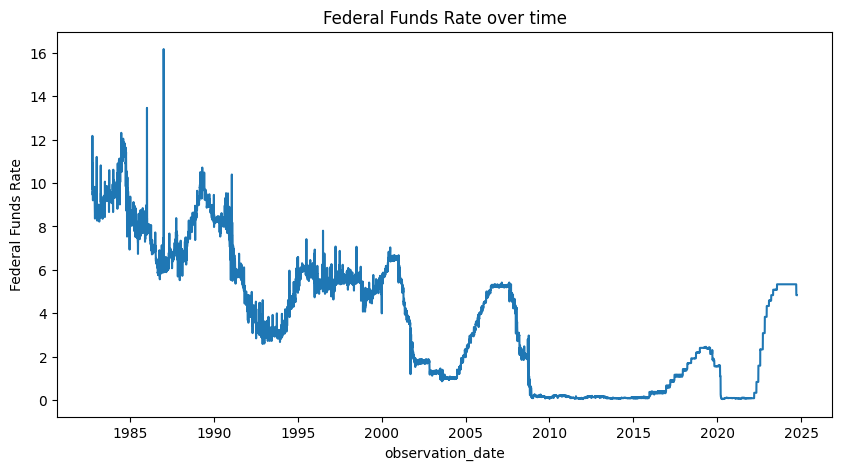

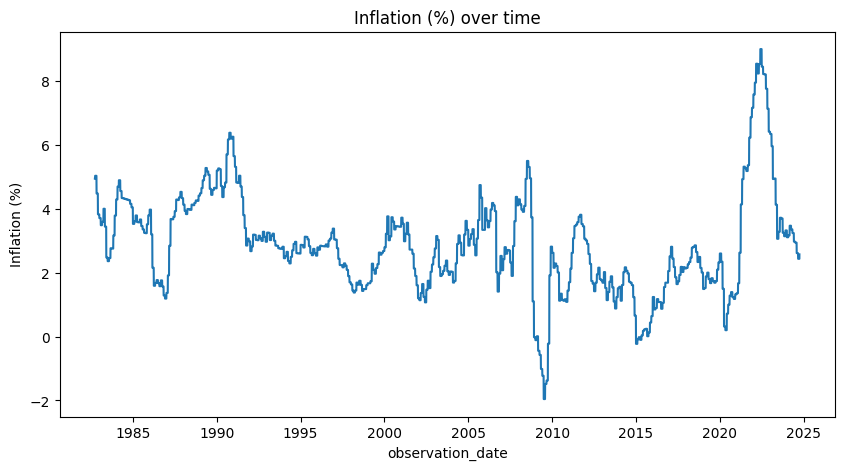

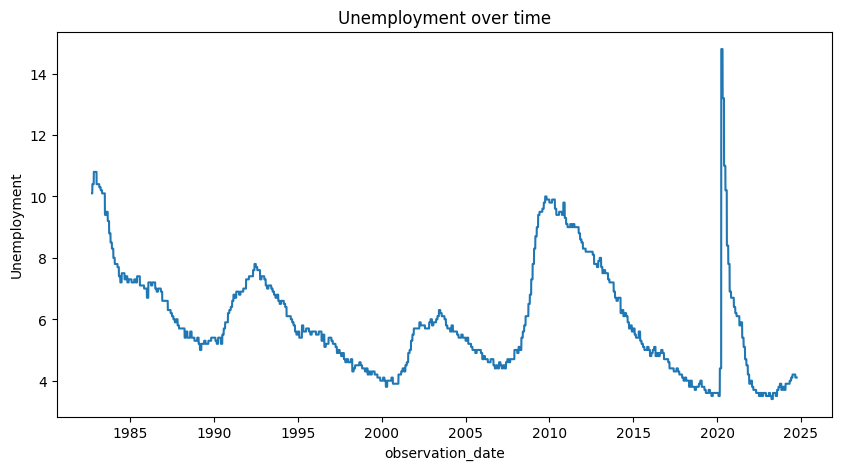

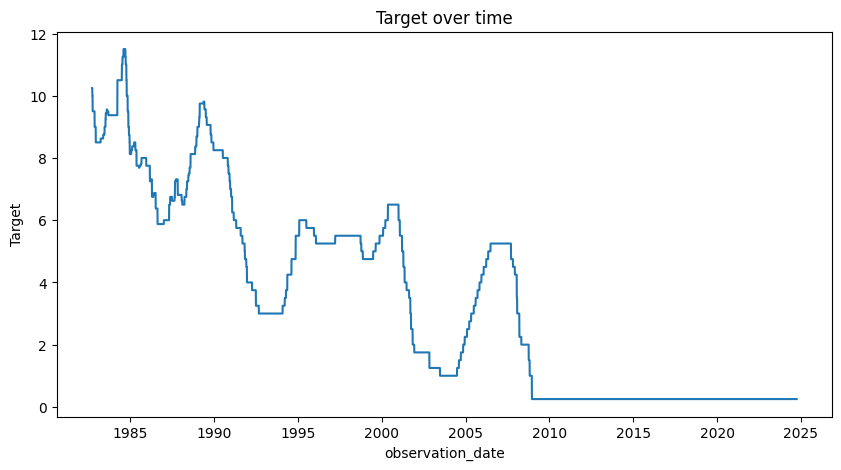

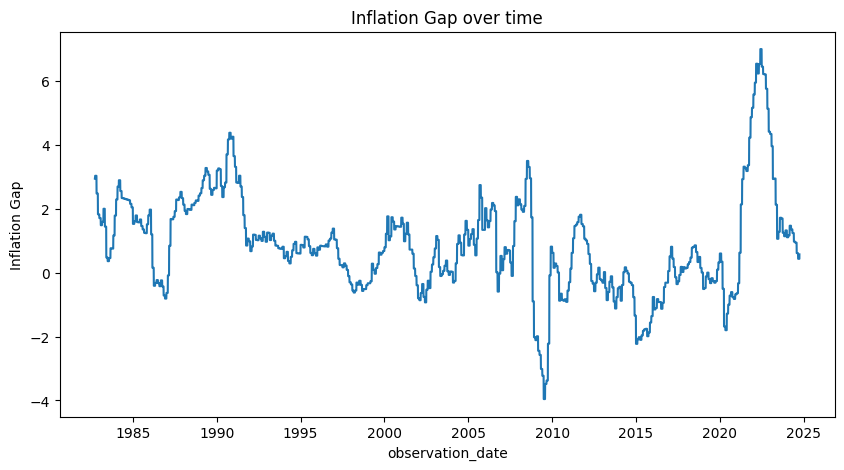

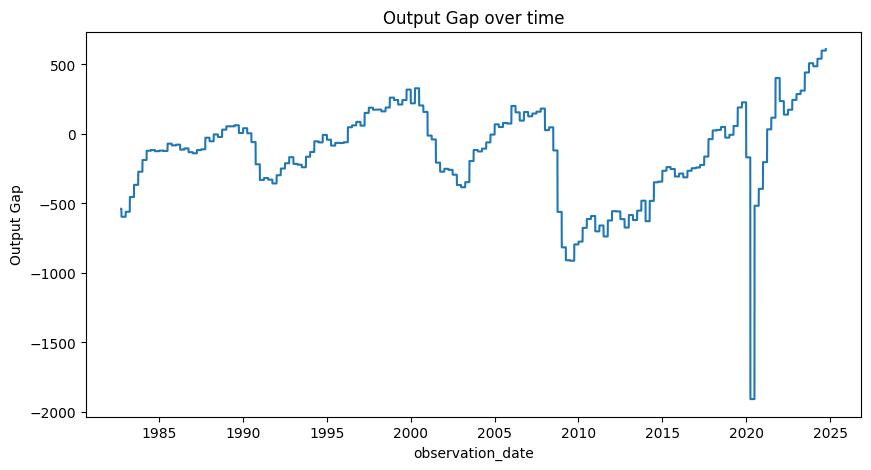

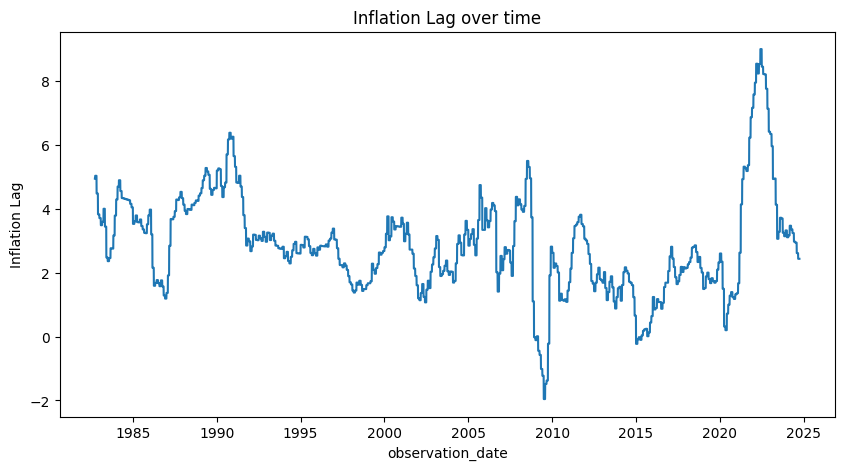

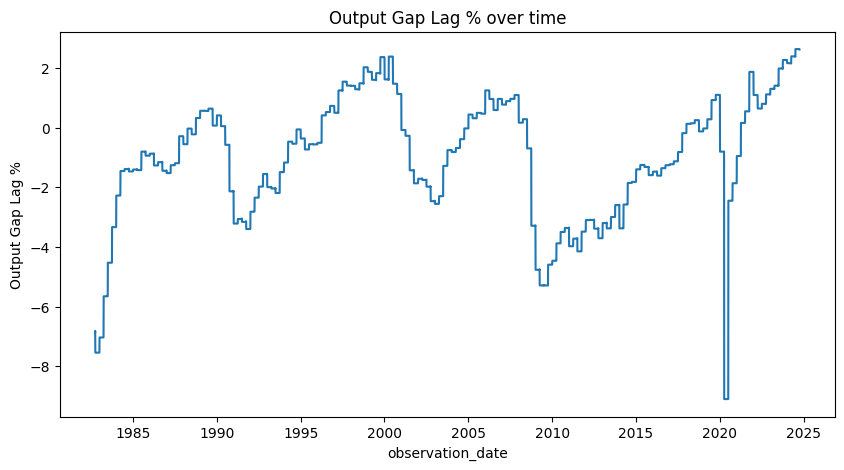

In [15]:
for column in df.columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(df[column])
    plt.title(f'{column} over time')
    plt.show()

The FFR and Target have been steadily decreasing since the 1980s. Inflation, Output Gap, and Unemployment have roughly remained around a constant level over time, despite having some sharp rises or drops.

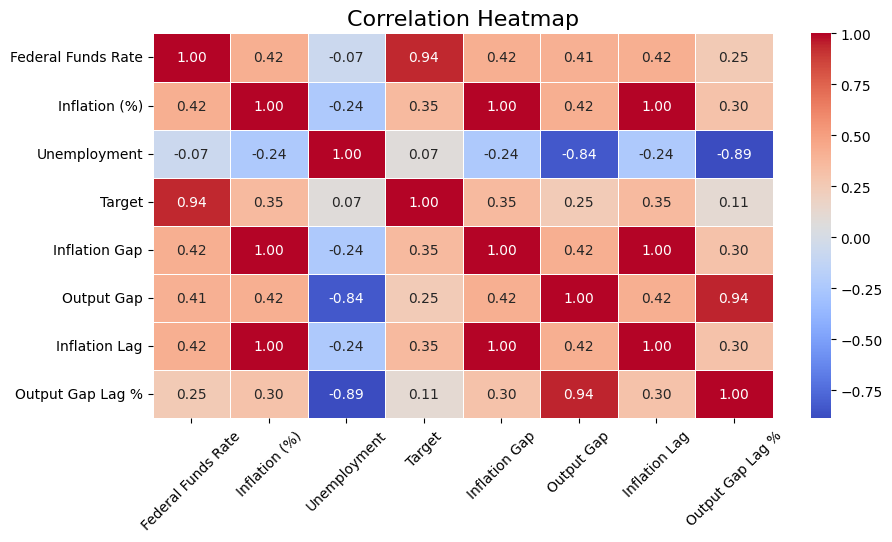

In [16]:
# Construct a Correlation Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(
    df.corr(),
    annot=True,  # Display correlation values
    cmap="coolwarm",
    fmt=".2f",  # Limit to 2 decimal places
    linewidths=0.5,
)
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

Inflation, Inflation Gap, and Inflation Lag are perfectly correlated to each other, while Output Gap and Output Gap Lag (%) are very strongly correlated, which is expected. We will not be trying any models that use more than 1 in each set as predictors at a time.

Unemployment and Output Gap are strongly correlated, so we will need to watch out for these when checking the Variance Inflation Factors (VIFs) for multicollinearity issues.

## Modeling

The variables used for each regression Model are listed as follows:

Taylor's Rule Model: 

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap

Karakas Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap Lag %, Inflation Lag (%)
    
Target Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Target
    
Unemployment Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Unemployment
    
Both Model (uses both Unemployment and Target):

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Target, Unemployment

In [17]:
# Apply Robust Scaler to independent variables
scaler = MinMaxScaler()
df_vars = ["Unemployment", "Target", "Inflation Gap", "Output Gap", "Output Gap Lag %", "Inflation Lag"]
df[df_vars] = scaler.fit_transform(df[df_vars])

In [18]:
# Set dependent variable
y = df["Federal Funds Rate"]

# Define independent variables for each model
model_features = {
    "Taylor": df[["Output Gap", "Inflation Gap"]],
    "Karakas": df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Initialize dictionaries to store results
ols_fitted_models = {}
ols_predictions = {}
ols_vif_results = {}
ols_error_metrics = {}
ols_model_statistics = {}

# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in model_features.items():
    X = sm.add_constant(X)
    
    # Fit the model
    model, y_pred = fit_ols_model(X, y, model_name)
    ols_fitted_models[model_name] = model
    ols_predictions[model_name] = y_pred

    # Calculate VIF
    vif_data = calculate_vif(X, model_name)
    ols_vif_results[model_name] = vif_data
   
    # Calculate error metrics
    metrics = error_metrics(y, y_pred)
    ols_error_metrics[model_name] = metrics
    
    # Extract model stats (coefficients, t-stats, and p-values)
    ols_model_statistics[model_name] = extract_model_stats(model, model_name)

## Regression Assumptions

In [19]:
# Dictionary to store assumption test results
ols_assumption_tests = {}
ols_residuals = {}

# Iterate through models
for model_name, model in ols_fitted_models.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    ols_assumption_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.6f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.6f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.6f}",
        "Rainbow Test p-value": f"{rainbow[1]:.6f}"
    }
    
# Print results
for model, results in ols_assumption_tests.items():
    print(f"\nAssumption Test Statistics and P-values for {model}:")
    for test, value in results.items():
        print(f"{test}: {value}")


Assumption Test Statistics and P-values for Taylor:
Durbin-Watson Test Statistic: 0.006315
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Karakas:
Durbin-Watson Test Statistic: 0.005727
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Target:
Durbin-Watson Test Statistic: 0.050719
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Unemployment:
Durbin-Watson Test Statistic: 0.011774
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Both:
Durbin-Watson Test Statistic: 0.054425
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000


The assumptions of regression include:

1. Normality of residuals
2. Homoscedasticity
3. Autocorrelation
4. Linearity
5. Multicollinearity

These assumptions can be tested using the Jarque-Bera test (Normality), Breusch-Pagan test(Homoscedasticity), Durbin-Watson test (Autocorrelation), and Rainbow test (Linearity).
For every model, the above p-values are all around 0 and the Durbin Watson test statistic lies between 0 and 0.5. 

H0: The model does not violate the regression assumption

H1: The model does violate the regression assumption

Using the 95% confidence level (significance level 0.05), the Jarque-Bera test, Breusch-Pagan test, and Rainbow test statistics all have p-values of around 0, which is less than the significance level. Therefore, we would reject the null hypothesis, H0, that the models do not violate the corresponding regression assumptions. 

For the Durbin-Watson test, statistics less than 1 or greater than 3 indicate strong autocorrelation and would violate the regression assumption of autocorrelation.

The models violates the first 4 regression Assumptions, which makes its results completely unreliable. 

In [20]:
# Print VIFs for all models
for model_name, vif_data in ols_vif_results.items():
    print(f"VIF for {model_name} Model:")
    print(vif_data)
    print("\n")

VIF for Taylor Model:
         Feature        VIF
0          const  30.635741
1     Output Gap   1.213277
2  Inflation Gap   1.213277


VIF for Karakas Model:
            Feature        VIF
0             const  20.560459
1  Output Gap Lag %   1.101762
2     Inflation Lag   1.101762


VIF for Target Model:
         Feature        VIF
0          const  30.998908
1     Output Gap   1.230175
2  Inflation Gap   1.318211
3         Target   1.157143


VIF for Unemployment Model:
         Feature         VIF
0          const  149.314096
1     Output Gap    4.023551
2  Inflation Gap    1.279972
3   Unemployment    3.513938


VIF for Both Model:
         Feature         VIF
0          const  195.845180
1     Output Gap    5.216976
2  Inflation Gap    1.331220
3         Target    1.523513
4   Unemployment    4.626507




From the VIFs, we do not have serious problems with multicollinearity. There is moderate level of multicollinearity for Output Gap in the Both Model, but it is rather close to 5, which is the threshold for moderate levels and should not cause major issues if left alone. Unemployment, the other variable of interest from our correlation matrix analysis, has acceptable multicollinearity levels. Every other model has VIFs below 5, and mostly around 1. There are no serious issues of multicollinearity, which is the only regression assumption that can be considered passable for the models.

## Metrics and Model Comparison

While all the regression assumptions except for Multicollinearity were violated and the results are unreliable, we can still compare our visualizations and metrics to Karakas's results and check if we reproduced their regression models, which is one objective of this project.

In [21]:
print(ols_fitted_models["Taylor"].summary())

                            OLS Regression Results                            
Dep. Variable:     Federal Funds Rate   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     2496.
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:54:33   Log-Likelihood:                -36682.
No. Observations:               15346   AIC:                         7.337e+04
Df Residuals:                   15343   BIC:                         7.339e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.7412      0.118    -31.695

In [22]:
print(ols_fitted_models["Karakas"].summary())

                            OLS Regression Results                            
Dep. Variable:     Federal Funds Rate   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     1830.
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:54:33   Log-Likelihood:                -37202.
No. Observations:               15346   AIC:                         7.441e+04
Df Residuals:                   15343   BIC:                         7.443e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.3727      0.100  

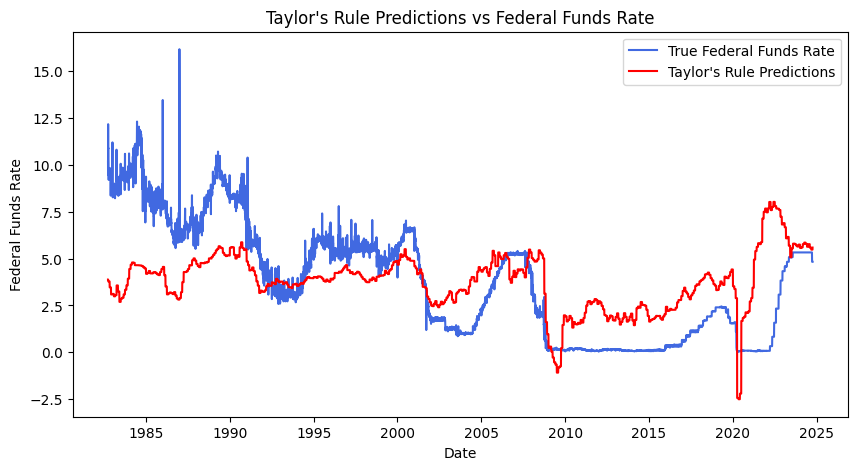

In [23]:
# Taylor Predictions vs Actual Plot
selected_model = "Taylor"

plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions[selected_model], label=f"{selected_model}'s Rule Predictions", color="red")
plt.title(f"{selected_model}'s Rule Predictions vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

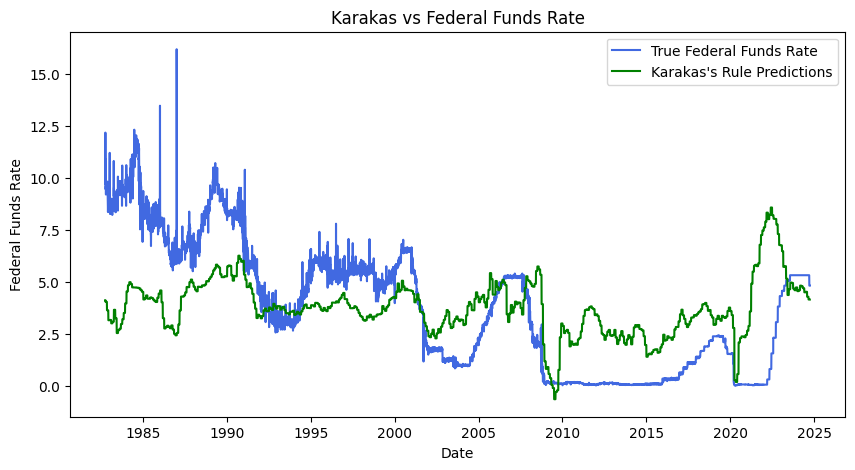

In [24]:
# Karakas Predictions vs Actual Plot
selected_model = "Karakas"

plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions[selected_model], label=f"{selected_model}'s Rule Predictions", color="green")
plt.title(f"{selected_model}'s Rule Predictions vs Federal Funds Rate")
plt.title("Karakas vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

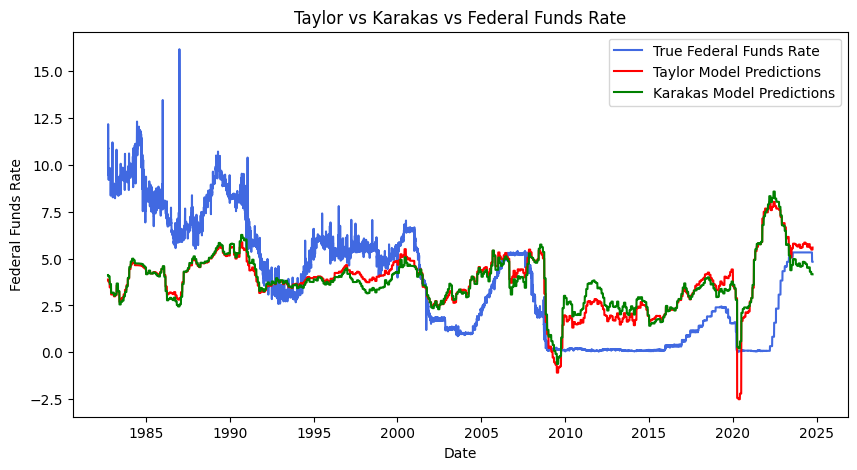

In [25]:
# Taylor Predictions vs Karakas Predictions vs Actual Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions["Taylor"], label="Taylor Model Predictions", color="red")
plt.plot(df.index, ols_predictions["Karakas"], label="Karakas Model Predictions", color="green")
plt.title("Taylor vs Karakas vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

The plots look similar to the ones shared in Karakas' (2023) paper. The date range is smaller in our plots, since the addition of other variables has restricted our date range due to missing values. However, for the dates that overlap between our plots and the ones Karakas shared in their paper, the plots do match. 

In [26]:
# Assuming y contains actual values and y_pred contains predicted values
RSS_taylor = np.sum((y - ols_predictions["Taylor"]) ** 2)
print(f"Residual Sum of Squares (RSS):")
print(f"RSS for Taylor: {RSS_taylor:.2f}")
RSS_karakas = np.sum((y - ols_predictions["Karakas"]) ** 2)
print(f"RSS for Karakas: {RSS_karakas:.2f}")
print("\n")

# Assuming y contains actual values and y_pred contains predicted values
print(f"Sum of Absolute Errors (SAE):")
SAE_taylor = np.sum(np.abs(y - ols_predictions["Taylor"]))
print(f"SAE for Taylor: {SAE_taylor:.2f}")
SAE_karakas = np.sum(np.abs(y - ols_predictions["Karakas"]))
print(f"SAE for Karakas: {SAE_karakas:.2f}")

Residual Sum of Squares (RSS):
RSS for Taylor: 107084.41
RSS for Karakas: 114591.35


Sum of Absolute Errors (SAE):
SAE for Taylor: 32459.75
SAE for Karakas: 34157.79


Like Karakas (2023), we found RSS and SAE values were higher for the Karakas Model. Having obtained similar results from the visualizations and metrics, we can consider our goal of reproducing the Taylor and Karakas Models successfully achieved. 

In [27]:
# Initialize a list to store model statistics
model_statistics = []

# Loop through the fitted models to extract key statistics
for model_name, model in ols_fitted_models.items():
    # Extract key values
    results = {
        "model": model_name,
        "r_squared": round(model.rsquared, 3),
        "adj_r_squared": round(model.rsquared_adj, 3),
        "aic": round(model.aic, 3),
        "bic": round(model.bic, 3),
        "f_stat": round(model.fvalue, 3),
    }
    

    # Append the results for each model
    model_statistics.append(results)

# Convert results to a DataFrame
statistics = pd.DataFrame(model_statistics)
statistics

,model,r_squared,adj_r_squared,aic,bic,f_stat
0,Taylor,0.245,0.245,73369.695,73392.611,2495.771
1,Karakas,0.193,0.192,74409.463,74432.379,1829.707
2,Target,0.914,0.914,40000.557,40031.112,54519.992
3,Unemployment,0.455,0.455,68387.366,68417.921,4264.691
4,Both,0.918,0.918,39233.919,39272.112,43184.403


Although the results may be unreliable, we find that the Taylor Model has higher values for R-squared, adjusted R-squared, but lower values for Akaike Information Criterion (AIC), and Bayesian Information Criterion (BIC) compared to the Karakas Model. The AIC and BIC are metrics that measure model quality, while considering complexity (number of features). Generally, the model with lower values for AIC and BIC is better than the model with higher values for them. This is consistent with how the Karakas Model explains less variance than the Taylor Model, as measured by R-squared.

While the results may not be reliable, notice that the inclusion of the Unemployment variable and the Target variable raises R-Squared very greatly. The Target Variable drives up R-Squared the most. Adding Unemployment to the model after including Target (resulting in the Both Model) raises R-Squared but only by a tiny amount. The inclusion of these two variables are still worth exploring in a different model.

In [28]:
# Print error metrics
for model_name, model in ols_error_metrics.items():
    print(f"{model_name} Model Error Metrics:")
    for metric, value in model.items():
        print(metric, value)
    print("\n")

Taylor Model Error Metrics:
Mean Squared Error: 6.978
Root Mean Squared Error: 2.642
Mean Absolute Error: 2.115
Mean Percentage Error: -505.251%
Mean Absolute Percentage Error: 598.282%


Karakas Model Error Metrics:
Mean Squared Error: 7.467
Root Mean Squared Error: 2.733
Mean Absolute Error: 2.226
Mean Percentage Error: -613.529%
Mean Absolute Percentage Error: 649.304%


Target Model Error Metrics:
Mean Squared Error: 0.793
Root Mean Squared Error: 0.891
Mean Absolute Error: 0.586
Mean Percentage Error: -65.056%
Mean Absolute Percentage Error: 141.546%


Unemployment Model Error Metrics:
Mean Squared Error: 5.043
Root Mean Squared Error: 2.246
Mean Absolute Error: 1.764
Mean Percentage Error: -431.769%
Mean Absolute Percentage Error: 560.757%


Both Model Error Metrics:
Mean Squared Error: 0.754
Root Mean Squared Error: 0.868
Mean Absolute Error: 0.589
Mean Percentage Error: -72.73%
Mean Absolute Percentage Error: 153.442%




The error metrics are also in favor of the Taylor Model having better performance over the Karakas Model. Karakas (2023) claimed that their model had more accurate predictions, but not by much, which we've found is not entirely correct. While the Karakas Model had better RSS and SAE values, which does indicate better fitness, other performance metrics show that, overall, the model does not perform as well as the Taylor Model, having larger average errors and percentage errors. The difference, however, is not very big.

## Outliers

We previously omitted the step of handling outliers. The reason for doing so is because any outliers in the dataset can be considered true values. Next, we will create a copy of the data, cap the outliers using Winsorization, and refit the models. We will set the percentage of extreme values to cap at 5%, which should remove most outliers with massive gaps from the rest of the data. Then we will check the regression assumptions again. Sometimes outliers may affect the models and cause violations of assumptions. We want to verify if this the case here.

In [29]:
# Define the percentage of extreme values to cap
winsor_limits = (0.05, 0.05)

# Apply Winsorization to all numeric columns except the dependent variable
df_winsorized = df.copy()
for col in df_winsorized.columns:
    if col != "Federal Funds Rate":
        df_winsorized[col] = winsorize(df_winsorized[col], limits=winsor_limits)

# Define model variables using Winsorized data
model_features_winsor = {
    "Taylor": df_winsorized[["Output Gap", "Inflation Gap"]],
    "Karakas": df_winsorized[["Output Gap Lag %", "Inflation Lag"]],
    "Target": df_winsorized[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": df_winsorized[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": df_winsorized[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Refit models
fitted_models_winsor = {}
for model_name, X in model_features_winsor.items():
    X = sm.add_constant(X)
    model, y_pred = fit_ols_model(X, df_winsorized["Federal Funds Rate"], model_name)
    fitted_models_winsor[model_name] = model

# Dictionary to store assumption test results
wins_assumption_tests = {}

# Iterate through models
for model_name, model in fitted_models_winsor.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    wins_assumption_tests[model_name] = {
        "Jarque-Bera Test Statistic": f"{jb_test[0]:.6f}",
        "Breusch-Pagan Test Statistic": f"{bp_test[0]:.6f}",
        "Rainbow Test Statistic": f"{rainbow[0]:.6f}",
        "Durbin-Watson Test Statistic": f"{dw_stat:.6f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.6f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.6f}",
        "Rainbow Test p-value": f"{rainbow[1]:.6f}"
    }
    
# Print results
for model, results in wins_assumption_tests.items():
    print(f"Assumption Test Statistics and P-values for {model}:")
    for test, value in results.items():
        print(f"{test}: {value}")
    print("\n")

Assumption Test Statistics and P-values for Taylor:
Jarque-Bera Test Statistic: 576.399990
Breusch-Pagan Test Statistic: 3130.800411
Rainbow Test Statistic: 10.359135
Durbin-Watson Test Statistic: 0.007095
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000


Assumption Test Statistics and P-values for Karakas:
Jarque-Bera Test Statistic: 222.641663
Breusch-Pagan Test Statistic: 2946.059032
Rainbow Test Statistic: 9.922229
Durbin-Watson Test Statistic: 0.006868
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000


Assumption Test Statistics and P-values for Target:
Jarque-Bera Test Statistic: 34728.963996
Breusch-Pagan Test Statistic: 2907.161147
Rainbow Test Statistic: 69.880358
Durbin-Watson Test Statistic: 0.044525
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000


Assumption Test Statistics and P-values for Unemployment:
Jarque-Bera Test Statistic: 1590.7626

Handling the outliers did not change the results of the hypothesis tests for any of the assumption checks. OLS Models will not work as is due to assumption violations. Let's try to transform the data and use some other models to see if we can satisfy the regression assumptions.

### Yeo Johnson Transform and OLS Model

In [30]:
# Column to exclude (dependent variable)
dependent_var = "Federal Funds Rate"

# Box-Cox transformation requires strictly positive data
epsilon = 1e-6  # Small constant to ensure positivity
columns_to_transform = [col for col in df.columns if col != dependent_var]

# Apply Yeo Johnson transformation to independent variables
yj_transformed_df = df_winsorized.copy()
for col in columns_to_transform:
    shifted_data = yj_transformed_df[col] + abs(yj_transformed_df[col].min()) + epsilon
    yj_transformed_df[col], lambda_value = yeojohnson(shifted_data)

# Apply Standard Scaler to independent variables
scaler = RobustScaler()
yj_vars = ["Unemployment", "Target", "Inflation Gap", "Output Gap", "Output Gap Lag %", "Inflation Lag"]
yj_transformed_df[yj_vars] = scaler.fit_transform(yj_transformed_df[yj_vars])

# Set dependent variable
y = yj_transformed_df["Federal Funds Rate"]

# Define independent variables for each model
yj_model_features = {
    "Taylor": yj_transformed_df[["Output Gap", "Inflation Gap"]],
    "Karakas": yj_transformed_df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": yj_transformed_df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": yj_transformed_df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": yj_transformed_df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Initialize dictionaries to store results
yj_fitted_models = {}
yj_predictions = {}

# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in yj_model_features.items():
    X = sm.add_constant(X)
    
    # Fit the model
    model, y_pred = fit_ols_model(X, y, model_name)
    yj_fitted_models[model_name] = model
    yj_predictions[model_name] = y_pred

# Dictionary to store assumption test results
yj_assumption_tests = {}

# Iterate through models
for model_name, model in yj_fitted_models.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    yj_assumption_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.6f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.6f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.6f}",
        "Rainbow Test p-value": f"{rainbow[1]:.6f}"
    }
    
# Print results
for model, results in yj_assumption_tests.items():
    print(f"\nDW Test Statistics and Assumption Test P-values for {model}:")
    for test, value in results.items():
        print(f"{test}: {value}")


DW Test Statistics and Assumption Test P-values for Taylor:
Durbin-Watson Test Statistic: 0.007171
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

DW Test Statistics and Assumption Test P-values for Karakas:
Durbin-Watson Test Statistic: 0.007090
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

DW Test Statistics and Assumption Test P-values for Target:
Durbin-Watson Test Statistic: 0.031118
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

DW Test Statistics and Assumption Test P-values for Unemployment:
Durbin-Watson Test Statistic: 0.010446
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

DW Test Statistics and Assumption Test P-values for Both:
Durbin-Watson Test Statistic: 0.031230
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000


Assumptions are still violated with Yeo Johnson Transform.

### Generalized Least Squares with AutoRegressive Errors (GLSAR) Model on Log transform

In [31]:
# Column to exclude (dependent variable)
dependent_var = "Federal Funds Rate"

# Log transformation requires strictly positive data
epsilon = 1e-6  # Small constant to handle zero or negative values
columns_to_transform = [col for col in df.columns if col != dependent_var]

# Apply Log Transformation to independent variables
log_transformed_df = df_winsorized.copy()
for col in columns_to_transform:
    if log_transformed_df[col].min() <= 0:
        # Shift data to ensure positivity
        shifted_data = log_transformed_df[col] + abs(log_transformed_df[col].min()) + epsilon
    else:
        shifted_data = log_transformed_df[col]
    
    # Apply log transformation
    log_transformed_df[col] = np.log(shifted_data)

# Apply RobustScaler to independent variables
independent_vars = ["Unemployment", "Target", "Inflation Gap", "Output Gap", "Output Gap Lag %", "Inflation Lag"]
scaler = RobustScaler()
log_transformed_df[independent_vars] = scaler.fit_transform(log_transformed_df[independent_vars])

# Set dependent variable
y = log_transformed_df["Federal Funds Rate"]

# Define independent variables for each model
log_model_features = {
    "Taylor": log_transformed_df[["Output Gap", "Inflation Gap"]],
    "Karakas": log_transformed_df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": log_transformed_df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": log_transformed_df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": log_transformed_df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Initialize dictionaries to store results
log_fitted_models = {}
log_predictions = {}

# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in log_model_features.items():
    X = sm.add_constant(X)
    
    # Fit the model
    model, y_pred = fit_glsar_model(X, y, model_name, rho=2)
    log_fitted_models[model_name] = model
    log_predictions[model_name] = y_pred



# Dictionary to store assumption test results
log_assumption_tests = {}

# Iterate through models
for model_name, model in log_fitted_models.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    log_assumption_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.6f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.6f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.6f}",
        "Rainbow Test p-value": f"{rainbow[1]:.6f}"
    }
    
# Print results
for model, results in log_assumption_tests.items():
    print(f"\nDW Test Statistics and Assumption Test P-values for {model}:")
    for test, value in results.items():
        print(f"{test}: {value}")


DW Test Statistics and Assumption Test P-values for Taylor:
Durbin-Watson Test Statistic: 0.004234
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Karakas:
Durbin-Watson Test Statistic: 0.004097
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Target:
Durbin-Watson Test Statistic: 0.004579
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Unemployment:
Durbin-Watson Test Statistic: 0.004255
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Both:
Durbin-Watson Test Statistic: 0.004602
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000


Assumptions are still violated with GSLAR models on a Log Transformation, however linearity is now satisfied.

### GLSAR on Box-Cox Transform

In [32]:
# Column to exclude (dependent variable)
dependent_var = "Federal Funds Rate"

# Box-Cox transformation requires strictly positive data
epsilon = 1e-6  # Small constant to ensure positivity
columns_to_transform = [col for col in df.columns if col != dependent_var]

# Apply Box-Cox transformation to independent variables
bc_transformed_df = df_winsorized.copy()
for col in columns_to_transform:
    shifted_data = bc_transformed_df[col] + abs(bc_transformed_df[col].min()) + epsilon
    bc_transformed_df[col], lambda_value = boxcox(shifted_data)

# Apply Standard Scaler to independent variables
scaler = RobustScaler()
bc_vars = ["Unemployment", "Target", "Inflation Gap", "Output Gap", "Output Gap Lag %", "Inflation Lag"]
bc_transformed_df[bc_vars] = scaler.fit_transform(bc_transformed_df[bc_vars])

# Set dependent variable
y = bc_transformed_df["Federal Funds Rate"]

# Define independent variables for each model
bc_model_features = {
    "Taylor": bc_transformed_df[["Output Gap", "Inflation Gap"]],
    "Karakas": bc_transformed_df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": bc_transformed_df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": bc_transformed_df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": bc_transformed_df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Initialize dictionaries to store results
bc_fitted_models = {}
bc_predictions = {}

# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in bc_model_features.items():
    X = sm.add_constant(X)
    
    # Fit the model
    model, y_pred = fit_glsar_model(X, y, model_name, rho=2)
    bc_fitted_models[model_name] = model
    bc_predictions[model_name] = y_pred

# Dictionary to store assumption test results
bc_assumption_tests = {}
bc_residuals = {}
# Iterate through models
for model_name, model in bc_fitted_models.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    bc_assumption_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.6f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.6f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.6f}",
        "Rainbow Test p-value": f"{rainbow[1]:.6f}"
    }
    
# Print results
for model, results in bc_assumption_tests.items():
    print(f"\nDW Test Statistics and Assumption Test P-values for {model}:")
    for test, value in results.items():
        print(f"{test}: {value}")


DW Test Statistics and Assumption Test P-values for Taylor:
Durbin-Watson Test Statistic: 0.004220
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Karakas:
Durbin-Watson Test Statistic: 0.004058
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Target:
Durbin-Watson Test Statistic: 0.004951
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Unemployment:
Durbin-Watson Test Statistic: 0.004229
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000

DW Test Statistics and Assumption Test P-values for Both:
Durbin-Watson Test Statistic: 0.004970
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 1.000000


Assumptions are still violated with GSLAR models on a Box-Cox Transformation, however linearity is satisfied.

### Generalized Least Squares (GLS) on Box-Cox Transform

In [33]:
# Compute sigma using OLS residuals
gls_sigma_matrices = {}  # Store sigma matrices for each model

for model_name, residuals in bc_residuals.items():
    sigma = np.diag(residuals**2)  # Weight matrix using squared residuals
    gls_sigma_matrices[model_name] = sigma
    
# Set dependent variable
y = bc_transformed_df["Federal Funds Rate"]

# Define independent variables for each model
gls_model_features = {
    "Taylor": bc_transformed_df[["Output Gap", "Inflation Gap"]],
    "Karakas": bc_transformed_df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": bc_transformed_df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": bc_transformed_df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": bc_transformed_df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Initialize dictionaries to store results
gls_fitted_models = {}
gls_predictions = {}

# Iterate through each model and fit GLS
for model_name, X in gls_model_features.items():
    X = sm.add_constant(X)
    
    # Retrieve the corresponding sigma matrix from OLS residuals
    sigma = gls_sigma_matrices.get(model_name, np.eye(len(X)))  # Default to identity if missing

    # Fit GLS model
    model, y_pred = fit_gls_model(X, y, model_name, sigma)
    gls_fitted_models[model_name] = model
    gls_predictions[model_name] = y_pred

# Dictionary to store assumption test results
gls_assumption_tests = {}

# Iterate through GLS models
for model_name, X in gls_fitted_models.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    gls_assumption_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.6f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.6f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.6f}",
        "Rainbow Test p-value": f"{rainbow[1]:.6f}"
    }

# Print assumption test results
for model, results in gls_assumption_tests.items():
    print(f"\nAssumption Test Statistics and P-values for {model}:")
    for test, value in results.items():
        print(f"{test}: {value}")


Assumption Test Statistics and P-values for Taylor:
Durbin-Watson Test Statistic: 0.013895
Jarque-Bera p-value: 0.000289
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Karakas:
Durbin-Watson Test Statistic: 0.013895
Jarque-Bera p-value: 0.000289
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Target:
Durbin-Watson Test Statistic: 0.013895
Jarque-Bera p-value: 0.000289
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Unemployment:
Durbin-Watson Test Statistic: 0.013895
Jarque-Bera p-value: 0.000289
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000

Assumption Test Statistics and P-values for Both:
Durbin-Watson Test Statistic: 0.013895
Jarque-Bera p-value: 0.000289
Breusch-Pagan p-value: 0.000000
Rainbow Test p-value: 0.000000


All assumptions are violated again (except multicollinearity which we are not checking here).

### Huber Regression on Box-Cox Transform

In [34]:
# Set dependent variable
y = bc_transformed_df["Federal Funds Rate"]

# Define independent variables for each model
huber_model_features = {
    "Taylor": bc_transformed_df[["Output Gap", "Inflation Gap"]],
    "Karakas": bc_transformed_df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": bc_transformed_df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": bc_transformed_df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": bc_transformed_df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}


# Initialize dictionary to store results
huber_models = {}
huber_predictions = {}

# Loop to fit models using Huber Regression (Robust Linear Model)
for model_name, X in huber_model_features.items():
    X = sm.add_constant(X)
    
    # Fit the Huber Regression model (Robust Linear Model)
    huber_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    huber_results = huber_model.fit()
    
    # Store the model
    huber_models[model_name] = huber_results
    
    # Get predictions from the Huber model
    predictions = huber_results.predict(X)
    huber_predictions[model_name] = predictions

# Dictionary to store assumption test results
huber_tests = {}

# Iterate through models for assumption tests
for model_name, huber_results in huber_models.items():
    residuals = huber_results.resid
    X = huber_results.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Autocorrelation Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)
    
    # Store results
    huber_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.6f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.6f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.6f}",
    }

# Print results
for model, results in huber_tests.items():
    print(f"\nAssumption Test Results for {model}:")
    for test, value in results.items():
        print(f"{test}: {value}")


Assumption Test Results for Taylor:
Durbin-Watson Test Statistic: 0.007331
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000

Assumption Test Results for Karakas:
Durbin-Watson Test Statistic: 0.007272
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000

Assumption Test Results for Target:
Durbin-Watson Test Statistic: 0.013084
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000

Assumption Test Results for Unemployment:
Durbin-Watson Test Statistic: 0.010643
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000

Assumption Test Results for Both:
Durbin-Watson Test Statistic: 0.013844
Jarque-Bera p-value: 0.000000
Breusch-Pagan p-value: 0.000000


The Rainbow test does not work on the Huber model, but the assumptions of Normality, Homoscedasticity, and Autocorrelation have still been violated.

## Conclusion

Karakas (2023) noted that Taylor's Rule (and their variant) do not predict the FFR well and changed their model to neural networks, getting better predictions by capturing non-linear patterns. We note that while Karakas obtained poor results from both regression models they constructed, since all regression assumptions except for Multicollinearity have been violated, the results of those regressions are unreliable. We noticed that Karakas did not mention regression assumptions in their paper, so we decided to check them as part of the validation process. The results came as a surprise to us as we were not expecting regression assumptions to be violated. 

Through our findings from this project, we believe we can explain why both of Karakas' regression models had poor predictive performance. None of the independent variables, including but not limited to those used in Karakas' models, have a linear relationship with the FFR, which may be the reason why a non-linear model works better. 

Karakas (2023) also mentioned their model having predictions closer to the actual FFR, but not by much. However, the error metrics we computed show that it is the Taylor Model, rather than the Karakas Model that has smaller average errors and percentage errors.

We have tested other regression models and transformations, but assumptions are still violated. Certain models and transformations may be able to satisfy linearity, but Normality, Homoscedastity, and Autocorrelation all remain problems. We believe that regression models are not well suited for predicting Taylor's Rule. We believe that non-linear models, such as neural networks, future research to predict the FFR should be focus on non-linear models. While the results may not be reliable due to violation of regression assumptions, it is worth noting that the inclusion of the Target and Unemployment variable did improve performance metrics. They are still worth considering and exploring in other models.

<h2><center>References</center></h2>

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Effective Rate [DFF]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFF

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Rate (DISCONTINUED) [DFEDTAR]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTAR

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Range - Lower Limit [DFEDTARL]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTARL

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Range - Upper Limit [DFEDTARU]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTARU

Karakas, A. D. (2023). Reevaluating the Taylor Rule with Machine Learning. ArXiv.org. https://arxiv.org/abs/2302.08323

U.S. Bureau of Economic Analysis. (2025). Real Gross Domestic Product [GDPC1]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/GDPC1

U.S. Bureau of Labor Statistics. (2025). Consumer Price Index for all urban consumers: All items in U.S. city average [CPIAUCSL]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/CPIAUCSL

U.S. Bureau of Labor Statistics. (2025). Unemployment Rate [UNRATE]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/UNRATE

U.S. Congressional Budget Office. (2025). Real Potential Gross Domestic Product [GDPPOT]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/GDPPOT